In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import time
import random
import pandas as pd

from scipy import signal

from ipywidgets import Image
from ipycanvas import Canvas

In [2]:
def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))

def show_image(img):
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [3]:
img = []
img4 = []
img_orig = []

### Load image

##### Insert white border around image

In [4]:
img = cv2.imread("map.png", cv2.IMREAD_GRAYSCALE);
backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB);
img = backtorgb.dot([0.33,0.33,0.33])

(my,mx)=img.shape
img[0,:]=255
img[:,0]=255
img[my-1,:]=255
img[:,mx-1]=255

img_orig = img.copy()

image_data = np.stack((backtorgb[:,:,0],backtorgb[:,:,1],backtorgb[:,:,2]), axis=2)

### Process Image to find middle point between tracks

##### Difference between subsequent dilations

In [5]:
difftmp = np.array([[1,1,1],[1,0,1],[1,1,1]])
kernel = np.ones((3,3),np.uint8)
img4 = np.zeros_like(img)*0
clas = True
while clas == True:
    img2 = cv2.dilate(img,kernel,iterations = 1)
    img3 = img2-img
    if np.sum(img3)==0:
        break
    
    ### Calculate number of white pixels around this pixel
    img4 = img4+(signal.convolve2d(img3,difftmp, boundary='symm', mode='same')/255>4)*255
    
    image_data = np.stack((img3+img4,img3+img_orig,img3), axis=2)
    img = img2.copy()
image_data = np.stack((img4,img4+img3,img4), axis=2)

### Get point at the border, using a point inside the clipped area, and angle.

In [6]:
def clip_line(point, angle, img_size):
    (x,y) = point
    (xx,yy) = img_size
        
    if angle>180:
        rad_angle = np.pi*(270-angle)/180
        x1 = 0
        y1 = y + x*np.tan(rad_angle)
        
        if y1>yy:
            rad_angle = np.pi*(angle-180)/180
            y1 = yy-1
            x1 = x-np.tan(rad_angle)*(yy-y)
    else:
        rad_angle = np.pi*(180-angle)/180
        y1 = yy-1
        x1 = x + np.tan(rad_angle)*(yy-y)
        
        if x1>xx:
            rad_angle = np.pi*(angle-90)/180
            x1 = xx-1
            y1 = y + np.tan(rad_angle)*(xx-x)
    
    return (int(x1),int(y1))

### Functions

1. **find_first_point**: return first point non-background inside image
2. **check_length_of_line**: find length of line 
3. **check_vals**: find length of line 
3. **find_line**: using a point do a 360degree scan to discover any lines getting out of the point. 

In [7]:
def find_first_point(img):
    (yy,xx)=img.shape
    for y in range(yy):
        for x in range(xx):
            if img[y,x]:
                return (x,y)
    return None

def check_vals(img,p1,p2,show=False):
    
    (yy,xx)=img.shape
    (x1,y1) = p2
    (x0,y0) = p1
    
    if x0>x1:
        (x0,y0) = (x1,y1)
        (x1,y1) = p1
    
    dx = x1 - x0
    dy = y1 - y0
    D = 2*dy - dx
    y = y0
    
    vals=0
    for x in range(x0,x1):
        if img[y,x]:
            vals=vals+1
        else:
            return vals
    
        if D > 0:
               y = y + 1
               D = D - 2*dx
        
        D = D + 2*dy
    return vals

def find_line(img,point):
    
    radius=20
    (yy,xx)=img.shape
    (x0,y0)=point
    xx=xx-1
    yy=yy-1
    
    (x,y)=point
    grp = {}
    
    for angle in range(90,269):
        rad_angle=np.pi*angle/180
        x1=x+int(radius*np.sin(rad_angle))
        y1=y-int(radius*np.cos(rad_angle))
        
        if x1<0: ## angle >180
            rad_angle=np.pi*(angle-180)/180
            x1=0
            y1=int(y+x/np.tan(rad_angle))
            
        if x1>xx:  ## angle <180
            rad_angle=np.pi*(180-angle)/180
            x1=xx
            y1=int(y+(xx-x)/np.tan(rad_angle))
                  
        if y1>yy:
            if angle>180:
                rad_angle=np.pi*(angle-180)/180
                y1=yy
                x1=int(x-(yy-y-1)*np.tan(rad_angle))
            else:
                rad_angle=np.pi*(180-angle)/180
                y1=yy
                x1=int(x+(yy-y)*np.tan(rad_angle))
        
        grp[angle]=check_vals(img,(x,y),(x1,y1), show=False)
        
    angle_wmax = max(grp, key=grp.get) ## return angle with highest peak
    return angle_wmax

In [8]:
def check_length_of_line(img,point,angle):
    
    (yy,xx)=img.shape
    (x1,y1) = clip_line(point, angle, (xx,yy))
    (x0,y0) = point
    
    if x0>x1:
        (x0,y0) = (x1,y1)
        (x1,y1) = point
    
    dx = x1 - x0
    dy = y1 - y0
    D = 2*dy - dx
    y = y0
    
    vals=0
    for x in range(x0,x1):
        if img[y,x]:
            vals=vals+1
        else:
            return (x,y)
    
        if D > 0:
               y = y + 1
               D = D - 2*dx
        
        D = D + 2*dy
    return vals

In [9]:
img_path = img4.copy()

t=0
ppline = []
p1 =1 
while (t<10000) and (p1!=None):
    t=t+1
    
    img_binary = img4!=0
    p1 = find_first_point(img_binary)
    if p1 != None:
        a1 = find_line(img_binary,p1)
        p2 = check_length_of_line(img_binary,p1,a1)
        cv2.line(img4,p1,p2,(0,0,0))
        ppline.append([p1,p2])
    

In [10]:
canvas2 = Canvas(width=mx, height=my)
canvas2

Canvas(height=400, width=640)

In [11]:
image_data = np.stack((img4,img4,img4), axis=2).astype(np.uint8)

lengths = []
for a in ppline:
    [(x,y),(x1,y1)]=a
    if (((x1-x)**2+(y1-y)**2)**0.5)>2:
        cv2.line(image_data,(x,y),(x1,y1),random_color())
        canvas2.put_image_data(image_data,0,0)
        canvas2
        time.sleep(0.5)
canvas2

Canvas(height=400, width=640)

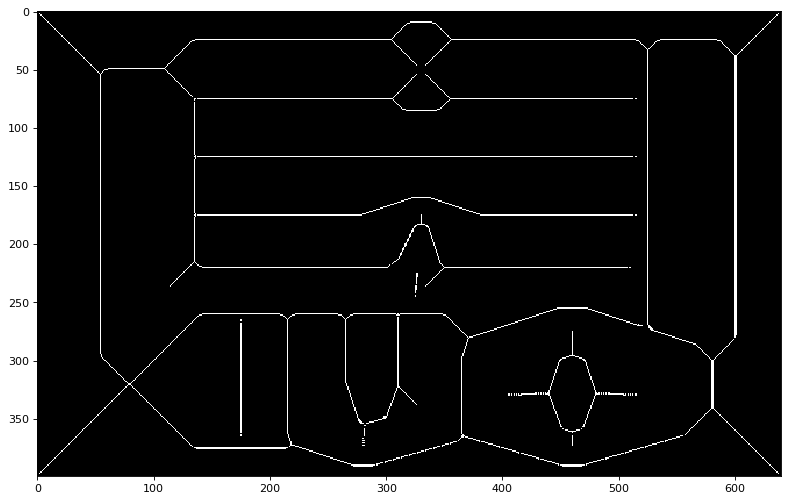

In [12]:
show_image(img_path)